In [2]:
from pandas import read_csv, concat
from pathlib import Path
import seaborn as sns
from matplotlib import pyplot as plt

general_path = Path('datasets', 'general')
diseased_path = Path('datasets', 'diseased')
general_datasets = ['cam-can', 'nkirs', 'sald', 'hcp', 'hcp-aging', 'ukbb']
diseased_datasets = ['oasis', 'aibl', 'adni']
splits = ['train', 'val']

# Read the datasets and combine them
def combine_datasets(datasets, splits, dataset_path):
    dataframes = []
    for dataset in datasets:
        for split in splits:
            file_path = dataset_path / dataset / 'splits' / f'{split}.csv'
            if file_path.exists():
                df = read_csv(file_path)
                if not df.empty:
                    df['split'] = split
                    dataframes.append(df)

    return concat(dataframes)

general_df = combine_datasets(general_datasets, splits, general_path)
diseased_df = combine_datasets(diseased_datasets, splits, diseased_path)
diseased_df = diseased_df[diseased_df['dx'] != 'Dementia Unspecified']
diseased_df = diseased_df.rename(columns={'dx': 'diagnosis'})

In [2]:
pretrained_exp_path = Path('pretrain_exp', 'datasets')
pretrained_csvs = list(pretrained_exp_path.glob('*.csv'))
pretrained_dfs = []
for csv in pretrained_csvs:
    df = read_csv(csv)
    if not df.empty:
        pretrained_dfs.append(df)
pretrained_df = concat(pretrained_dfs)
pretrained_df = pretrained_df.rename(columns={'dx': 'diagnosis'})
pretrained_df = pretrained_df.drop_duplicates(subset=['image_id'])
print('Size of pretrained_df:', pretrained_df.shape[0])
print('Size of diseased_df:', diseased_df.shape[0])

Size of pretrained_df: 4032
Size of diseased_df: 4115


In [3]:
# check if there are images in pretrained_df but not in diseased_df and vice versa
pretrained_subject_ids = set(pretrained_df['subject_id'])
diseased_subject_ids = set(diseased_df['subject_id'])
print('Pretrained subject IDs not in diseased:', len(pretrained_subject_ids - diseased_subject_ids))
print('Diseased subject IDs not in pretrained:', len(diseased_subject_ids - pretrained_subject_ids))

pretrained_images = set(pretrained_df['image_id'])
diseased_images = set(diseased_df['image_id'])
print('Pretrained images not in diseased:', len(pretrained_images - diseased_images))
print('Diseased images not in pretrained:', len(diseased_images - pretrained_images))

Pretrained subject IDs not in diseased: 5
Diseased subject IDs not in pretrained: 88
Pretrained images not in diseased: 246
Diseased images not in pretrained: 329


Number of images in diseased_df not in pretrained_df: 234


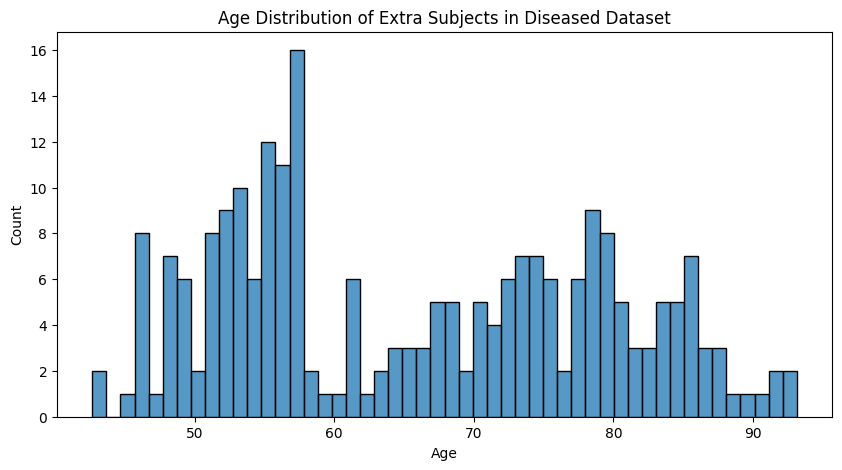

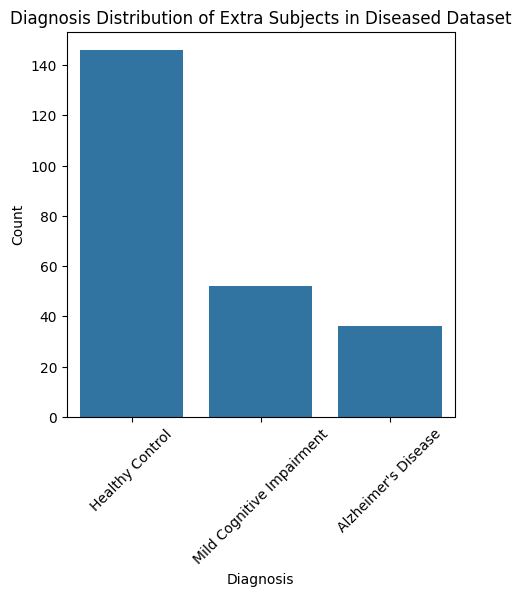

In [9]:
# check age distribution of the extra subjects in diseased_df
in_diseased_but_not_in_pretrained = diseased_df[~diseased_df['subject_id'].isin(pretrained_df['subject_id'])]
print('Number of images in diseased_df not in pretrained_df:', in_diseased_but_not_in_pretrained.shape[0])
# plot its age distribution
plt.figure(figsize=(10, 5))
sns.histplot(data=in_diseased_but_not_in_pretrained, x='age_at_scan', bins=50)
plt.title('Age Distribution of Extra Subjects in Diseased Dataset')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()
# plot their diagnosis (column 'dx')
plt.figure(figsize=(5, 5))
sns.countplot(data=in_diseased_but_not_in_pretrained, x='diagnosis')
plt.title('Diagnosis Distribution of Extra Subjects in Diseased Dataset')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## General population

In [37]:
# describe statistics across datasets and splits (number of samples, age range, female-male ratio, mean age and std)
stats = general_df.groupby(['dataset', 'split']).agg(
    n_samples=('subject_id', 'count'),
    mean_age=('age_at_scan', 'mean'),
    quartile_1_age=('age_at_scan', lambda x: x.quantile(0.25)),
    quartile_2_age=('age_at_scan', lambda x: x.quantile(0.75)),
    female_ratio=('gender', lambda x: x.value_counts(normalize=True).get('female', 0)),
    bmi=('bmi', 'mean'),
    std_bmi=('bmi', 'std'))

stats

n_samples   mean_age  quartile_1_age  quartile_2_age  \
dataset   split                                                         
cam-can   train        285  43.677474       33.500000       53.750000   
          val          106  50.270849       39.187500       63.937500   
hcp       train        429  28.792541       26.000000       32.000000   
          val          155  28.800000       26.000000       32.000000   
hcp-aging train        270  60.583951       46.791667       76.187500   
          val           79  60.093882       46.875000       75.166667   
nkirs     train        404  46.004950       28.000000       60.000000   
          val          109  50.563212       33.000000       65.000000   
sald      train        229  49.502183       34.000000       61.000000   
          val           76  50.855263       39.250000       65.000000   
ukbb      train      31493  64.077692       58.085558       70.080082   
          val         4216  63.949024       58.028234       69.941478   

                 female_ratio        bmi   std_bmi  
dataset   split                                     
cam-can   train      0.480702        NaN       NaN  
          val        0.584906        NaN       NaN  
hcp       train      0.564103  26.833061  5.407648  
          val        0.554839  26.325290  5.035995  
hcp-aging train      0.488889  26.913432  4.546402  
          val        0.594937  26.999263  4.340424  
nkirs     train      0.670792        NaN       NaN  
          val        0.642202        NaN       NaN  
sald      train      0.624454        NaN       NaN  
          val        0.592105        NaN       NaN  
ukbb      train      0.523005  26.515324  4.384184  
          val        0.526803  26.455635  4.404733

### Plot age

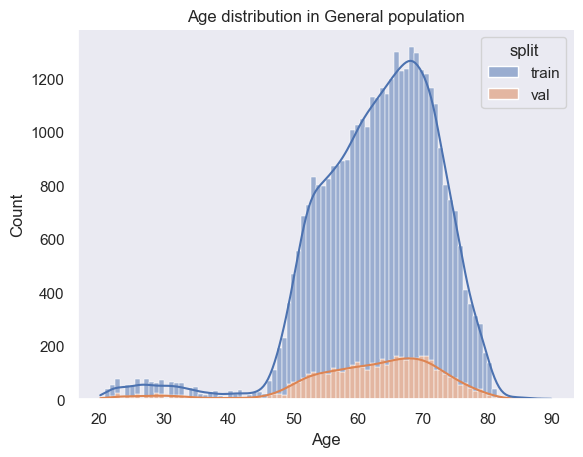

In [12]:
sns.set_theme()
sns.set_style({'axes.grid' : False})
sns.histplot(data=general_df, x='age_at_scan', hue='split', multiple='stack', alpha=0.5, legend=True, kde=True)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age distribution in General population')
sns.despine()
plt.savefig('age_distribution_general.png', dpi=300, transparent=True)
plt.show()

### Plot sex

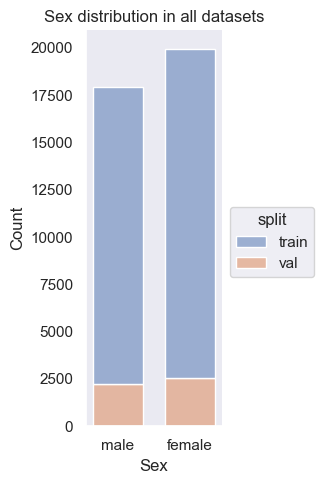

In [ ]:
sns.set_theme()
# make the figure bigger so that everything fits when it is saved
plt.figure(figsize=(3, 5))
sns.set_style({'axes.grid' : False})
sns.histplot(data=general_df, x='gender', hue='split', multiple='stack', alpha=0.5, legend=True, shrink=.7)
sns.move_legend(plt.gca(), "center right", bbox_to_anchor=(1.1, 0.5), bbox_transform=plt.gcf().transFigure)
plt.xlabel('Sex')
plt.ylabel('Count')
plt.title('Sex distribution in all datasets')
sns.despine()
plt.tight_layout()
plt.savefig('sex_distribution_general.png', dpi=300, transparent=True)
plt.show()

### Plot BMI

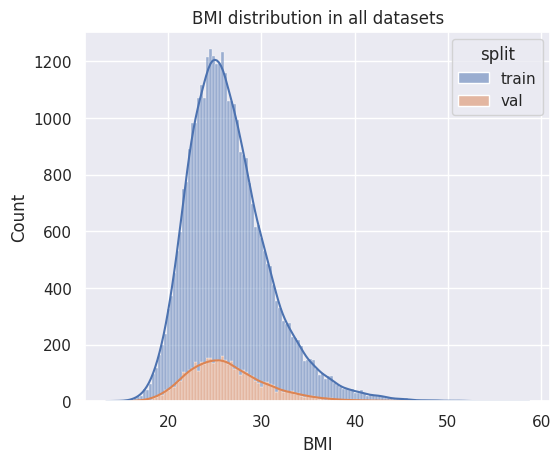

In [94]:
without_nas_in_bmi = general_df.dropna(subset=['bmi'])
sns.set_theme(rc={'figure.figsize':(6, 4.8)})
sns.histplot(data=without_nas_in_bmi, x='bmi', hue='split', multiple='stack', alpha=0.5, legend=True, kde=True)
plt.xlabel('BMI')
plt.ylabel('Count')
plt.title('BMI distribution in all datasets')
plt.show()

## Diseased

In [12]:
stats = diseased_df.groupby(['dataset']).agg(
    n_samples=('subject_id', 'count'),
    min_age=('age_at_scan', 'min'),
    max_age=('age_at_scan', 'max'),
    mean_age=('age_at_scan', 'mean'),
    std_age=('age_at_scan', 'std'),
    females=('gender', lambda x: (x == 'female').sum()),
    female_ratio=('gender', lambda x: x.value_counts(normalize=True).get('female', 0)),)

stats

,n_samples,min_age,max_age,mean_age,std_age,females,female_ratio
dataset,,,,,,,
adni,2527,50.500000,91.500000,72.921856,7.416701,1227,0.485556
aibl,683,55.000000,93.000000,72.861132,6.548579,387,0.566618
oasis,905,42.663927,93.932924,70.264723,8.832334,504,0.556906


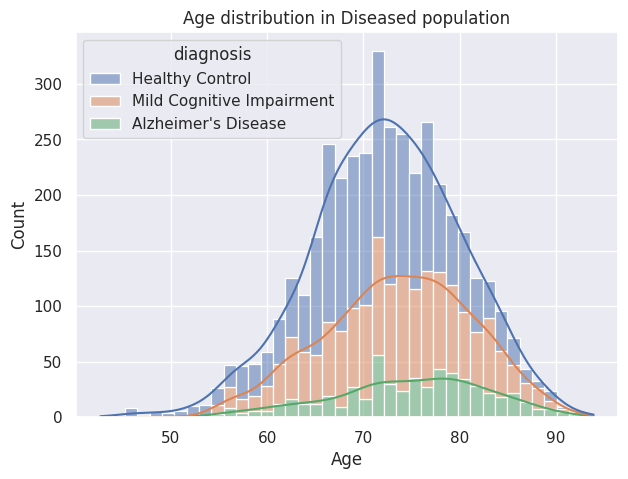

In [ ]:
plt.figure(figsize=(7, 5))
sns.set_theme()
sns.set_style({'axes.grid' : False})
sns.histplot(data=diseased_df, x='age_at_scan', hue='diagnosis', multiple='stack', alpha=0.5, legend=True, kde=True)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age distribution in Diseased population')
sns.despine()
plt.savefig('age_distribution_diseased.png', dpi=300, transparent=True)
plt.show()

In [32]:

def plot_balanced_distributions(balanced_dvh, balanced_dvp, balanced_hvp):
    balanced_dvh['dataset'] = 'AD vs. HC'
    balanced_dvp['dataset'] = 'AD vs. MCI'
    balanced_hvp['dataset'] = 'MCI vs. HC'

    # Capitalize gender values
    balanced_dvh['gender'] = balanced_dvh['gender'].str.capitalize()
    balanced_dvp['gender'] = balanced_dvp['gender'].str.capitalize()
    balanced_hvp['gender'] = balanced_hvp['gender'].str.capitalize()

    sns.reset_defaults()
    # Set up the figure with two axes: one for violin plots, one for gender bar plots
    fig = plt.figure(constrained_layout=True, figsize=(8, 4))
    gs = fig.add_gridspec(3, 2, width_ratios=[2, 1], height_ratios=[1, 1, 1])

    # Create the main violin plot axis
    ax_violin = fig.add_subplot(gs[:, 0])

    # Plot each dataset separately to ensure proper split violins
    datasets_data = [
        (balanced_dvh, 'AD vs. HC', 0),
        (balanced_dvp, 'AD vs. MCI', 1), 
        (balanced_hvp, 'MCI vs. HC', 2)
    ]

    # Get unique classes for consistent coloring
    all_classes = concat([balanced_dvh, balanced_dvp, balanced_hvp])['dx'].unique()
    colors = sns.color_palette('deep', n_colors=len(all_classes))
    class_color_map = dict(zip(all_classes, colors))

    # Plot split violins for each dataset
    for data, dataset_name, x_pos in datasets_data:
        # Create a temporary dataframe for this dataset only
        temp_df = data.copy()
        
        # Use seaborn's violinplot with split=True for this specific dataset
        sns.violinplot(
            data=temp_df,
            x=[dataset_name] * len(temp_df),  # All rows get the same x value
            y='age_at_scan',
            hue='dx',
            split=True,
            inner='quartile',
            ax=ax_violin,
            palette=[class_color_map[cls] for cls in temp_df['dx'].unique()]
        )

    # Customize the violin plot
    ax_violin.set_title('Age distribution')
    ax_violin.set_xlabel('')  # Remove xlabel
    ax_violin.set_ylabel('Age')
    # Remove grid lines except for axes
    ax_violin.grid(False)
    ax_violin.set_axisbelow(True)
    # Remove top and right spines
    ax_violin.spines['top'].set_visible(False)
    ax_violin.spines['right'].set_visible(False)

    # Remove the default legend from violin plot
    ax_violin.get_legend().remove()

    # Gender bar plots, stacked vertically, one for each dataset
    datasets = ['AD vs. HC', 'AD vs. MCI', 'MCI vs. HC']
    datasets_df = [balanced_dvh, balanced_dvp, balanced_hvp]

    for i, (ds, df) in enumerate(zip(datasets, datasets_df)):
        ax_bar = fig.add_subplot(gs[i, 1])
        sns.countplot(
            data=df,
            y='gender',
            hue='dx',
            ax=ax_bar,
            palette=[class_color_map[cls] for cls in df['dx'].unique()]
        )
        # Set ylabel to dataset name and remove xlabel
        ax_bar.set_ylabel(ds)
        ax_bar.set_xlabel('')  # Remove xlabel
        # Add title only to the top plot
        if i == 0:
            ax_bar.set_title('Sex distribution')
        # Remove all grid lines
        ax_bar.grid(False)
        # Remove top and right spines
        ax_bar.spines['top'].set_visible(False)
        ax_bar.spines['right'].set_visible(False)
        # Remove legend from all count plots
        ax_bar.get_legend().remove()

    # Create custom legend at center bottom with 3 columns
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=class_color_map[cls], alpha=0.7, label=cls) 
                    for cls in all_classes]
    fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.08), ncol=3)
    plt.tight_layout()
    plt.show()
    return fig

/tmp/ipykernel_17883/3725177572.py:93: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


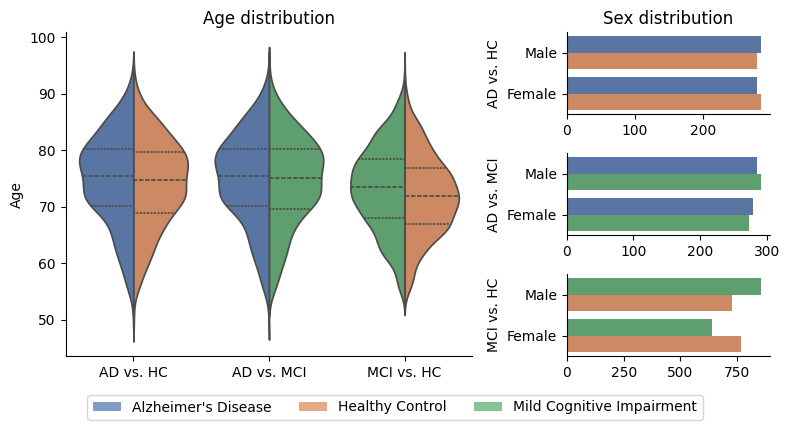

In [ ]:
balanced_dvh = read_csv('balanced_dvh.csv')
balanced_dvp = read_csv('balanced_dvp.csv')
balanced_hvp = read_csv('balanced_hvp.csv')

fig_balanced = plot_balanced_distributions(balanced_dvh, balanced_dvp, balanced_hvp)
fig_balanced.savefig('diseased_balanced_distributions.png', bbox_inches='tight', dpi=150)